In [115]:
from rtlsdr import RtlSdr 
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision = 2)

In [116]:
try: 
    sdr.close()
    print("Closed old SDR")
except NameError:
   print("No SDR instance found")

Closed old SDR


In [117]:
sdr = RtlSdr()

### Data Collection

In [118]:
fsps = 1048576      # 1         Msps
fc = 849.115e6      # 849.115   MHz
bitrate = 1         # 1         ksps

dt = 1.0 / fsps
nyquist = fsps / 2.0
Tmax = 0.1
N = round(fsps * Tmax)

bitperiod = 1 / bitrate
sampsperbit = round(fsps / bitrate)

sdr.sample_rate = fsps 
sdr.center_freq = fc
sdr.gain = 30

print("sample size is ", N)
print("sampling rate is ", fsps)
print("center frequency is ", fc)

sample size is  104858
sampling rate is  1048576
center frequency is  849115000.0


In [119]:
samples = sdr.read_samples(N)

### Filtering

#TODO
Move away from Zero-IF to avoid DC offset
(intuitively, modulate signal away from DC noise @ 0Hz caused by hardware imperfections)

In [120]:
def squelch(signal, p):
    abs = np.abs(signal)
    threshold = np.ptp(abs) * p
    res = np.copy(signal)
    for i in range(len(signal)):
        if (abs[i] < threshold):
            res[i] = 0.0
    return res

C:\Users\amitf\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


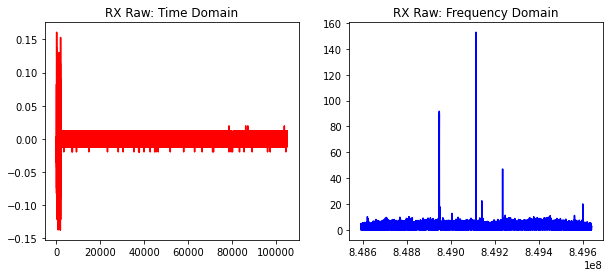

In [121]:
spectrum = np.fft.fftshift(np.fft.fft(samples))
maxval = np.amax(np.abs(spectrum))
maxindi = np.argmax(np.abs(spectrum))
freqs = np.linspace(fc-nyquist,fc+nyquist,len(spectrum))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.set_title("RX Raw: Time Domain")
ax1.plot(samples, color='red')

ax2.set_title("RX Raw: Frequency Domain")
ax2.plot(freqs, np.abs(spectrum), color='blue')

C:\Users\amitf\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


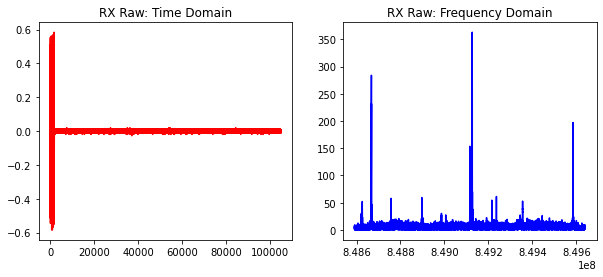

In [100]:
# squelch in time domain
sq_samples = samples - squelch(samples, 0.8)
sq_spectrum = np.fft.fftshift(np.fft.fft(sq_samples))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.set_title("RX Raw: Time Domain")
ax1.plot(sq_samples, color='red')

ax2.set_title("RX Raw: Frequency Domain")
ax2.plot(freqs, np.abs(sq_spectrum), color='blue')

C:\Users\amitf\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


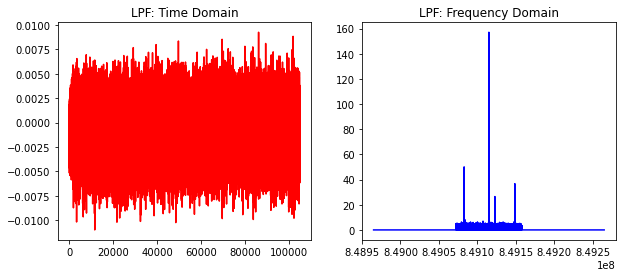

In [66]:
# low pass filter
def bandpassmask(N, fsps, fcutoff):
    fnyq = fsps / 2.0
    fcutoff_nyq = fcutoff / fnyq 
    midwidth = round(fcutoff_nyq*N)
    zerowidth = int((N-midwidth)/2)
    res = np.concatenate((np.zeros(zerowidth),np.ones(midwidth),np.zeros(zerowidth)))
    res = np.concatenate((res, np.zeros(N - len(res))))
    return(res)

lpf = 150e3

lpf_spectrum = bandpassmask(N, fsps, lpf) * spectrum
lpf_signal = np.fft.ifft(np.fft.fftshift(lpf_spectrum))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.set_title("LPF: Time Domain")
ax1.plot(lpf_signal, color='red')

ax2.set_title("LPF: Frequency Domain")
lpf_freqs = np.linspace(fc - lpf,fc + lpf, len(lpf_spectrum))
ax2.plot(lpf_freqs, np.abs(lpf_spectrum), color='blue')

C:\Users\amitf\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


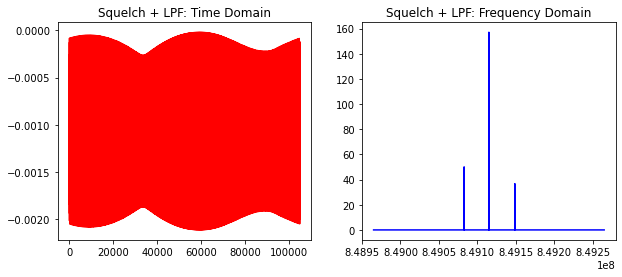

In [68]:


sq_lpf_spectrum = squelch(lpf_spectrum, 0.2)
sq_lpf_signal = np.fft.ifft(np.fft.fftshift(sq_lpf_spectrum))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.set_title("Squelch + LPF: Time Domain")
ax1.plot(sq_lpf_signal, color='red')

ax2.set_title("Squelch + LPF: Frequency Domain")
ax2.plot(lpf_freqs, np.abs(sq_lpf_spectrum), color='blue')

### FSK Decoding

In [69]:
filteredsignal = sq_lpf_signal

In [70]:
# compute theta
theta = np.arctan2(filteredsignal.imag, filteredsignal.real)

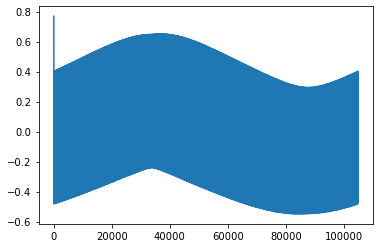

In [71]:

# compute phase derivative (= frequency) with 0, +pi comparison method
derivthetap0 = np.convolve([1,-1], theta,'same')
derivthetapp = np.convolve([1,-1], (theta+np.pi) % (2*np.pi),'same')
derivtheta = np.zeros(len(derivthetap0))
for i in range(len(derivthetap0)):
    if (abs(derivthetap0[i]) < abs(derivthetapp[i])):
        derivtheta[i] = derivthetap0[i] 
    else:
        derivtheta[i] = derivthetapp[i] 
plt.plot(derivtheta)

In [72]:
# remove frequency spikes
def smooth(theta):
    cdtheta = np.copy(derivtheta)
    spikethresh = 2
    for i in range(1, len(derivtheta)-1):
        if (abs(derivtheta[i])>spikethresh):
            cdtheta[i] = (derivtheta[i-1]+derivtheta[i+1])/2.0
    return cdtheta

cdtheta = smooth(derivtheta)

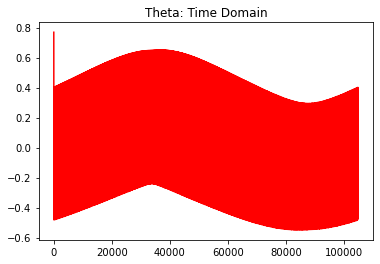

In [73]:
plt.title("Theta: Time Domain")
plt.plot(cdtheta, color = 'red')

In [77]:
# decimation
dec_factor = 18
dec_cdtheta = cdtheta[::dec_factor]
dec_sampsperbit = round(sampsperbit / dec_factor)

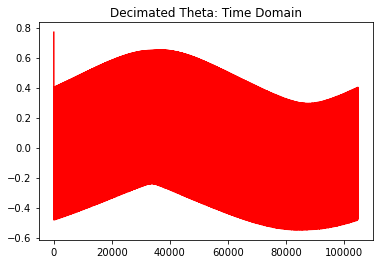

In [78]:
plt.title("Decimated Theta: Time Domain")
plt.plot(cdtheta, color = 'red')

In [81]:
dec_sampsperbit

58254

In [84]:
len(dec_cdtheta)

5826

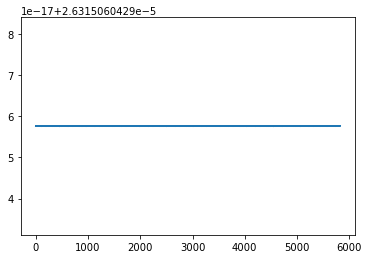

In [80]:
# convolve with tophat
def convolve_with_tophat(input_array, tophat_length):
    n = len(input_array)
    m = tophat_length
    tophat = np.ones(m) / m
    padded_array = np.pad(input_array, (m // 2, m // 2), mode='constant')
    result = np.zeros(n)
    for i in range(n):
        result[i] = np.sum(padded_array[i:i+m] * tophat)
    return result

dem = convolve_with_tophat(dec_cdtheta, dec_sampsperbit)

# round each theta to -1 or 1
dem_sign = np.sign(dem)

plt.plot(dem)

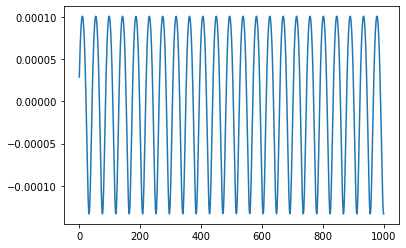

In [ ]:
plt.plot(dem[3000:4000])

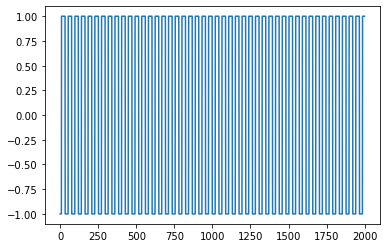

In [ ]:
plt.plot(dem_sign[8000:10000])

In [ ]:
dec_sampsperbit

1049

In [ ]:
# edge detection
win = 10
edge = win
while edge < len(dem_sign) - win:
    if np.abs(np.mean(dem_sign[edge - win:edge]) - np.mean(dem_sign[edge:edge + win])) > 1:
        break
    edge += 1

if (edge == len(dem_sign)):
    print("No edge found.")

print("edge: %d" % edge)

edge: 521


In [ ]:
# sample bits
rxdata = np.array([])
i = edge + dec_sampsperbit // 2
while i < len(dem_sign):
    rxdata = np.concatenate((rxdata, np.array([dem_sign[i]])))
    i += dec_sampsperbit
rxdata = (rxdata + 1) / 2


In [ ]:
print(rxdata)

[0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1.
 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1.
 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 0.]


In [ ]:
# theta_diff = np.abs(np.angle(sq_lpf_signal[:-1] * np.conj(sq_lpf_signal[1:])))
# dem = theta_diff - np.mean(theta_diff)
# plt.figure()
# plt.plot(dem)

In [ ]:
# plt.figure()
# spectrum = np.fft.fftshift(np.fft.fft(dem))
# maxval = np.amax(np.abs(spectrum))
# maxindi = np.argmax(np.abs(spectrum))
# freqs = np.linspace(fc-nyquist,fc+nyquist,len(spectrum))
# plt.plot(freqs, np.abs(spectrum))
# plt.savefig(fname="BX")